In [3]:
# Force reload (if changes have been made to the module)
%load_ext autoreload
%autoreload 2

from functions_atomFF import *

Python version:  3.11.3
Numpy version:  1.24.2
Vegas version:  6.1.3
PETITE home directory: /Users/samuelpatrone/Desktop/Samuel/PhD/Papers/04 - SHIP ALPs/PETITE
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
E0 = 100. # energy of incident photon in GeV
px, py, pz = 0, 0, E0
particle_dict = {'PID':22, 'ID':0, 'generation_number':0, 'generation_process':'Input'}
p0 = Particle([E0, px, py, pz], [0,0,0], particle_dict)

# Shower(directory, material, minimum_energy)
sGraphite = Shower(PETITE_home_dir+dictionary_dir, "graphite", 0.010)
sLead = Shower(PETITE_home_dir+dictionary_dir, "lead", 0.010)

Nprimary=50
# omega_min=0.01

# photons=photons_from_Nprimary(sLead,p0,Nprimary,omega_min=omega_min,plothisto=True)
#checkandsave('photons_50showers_omegamin1e-2_sLead',photons)
with open('DATA/photons_50showers_omegamin1e-2_sLead', 'rb') as f:
    photons = pickle.load(f)

# malist=[0.05,0.1,0.2,0.4,0.6,0.8,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2,2.1]
# axions={}
# for ma in malist:
#     params=params_dict(sLead,ma)
#     axions[ma]=axions_weights_update(sLead,axion_shower_primakhoff(sLead, photons, params),params)
# checkandsave('DATA/Primakoff_axion_atomFF/axions_lead_50showers',axions)

with open('DATA/Primakoff_axion_atomFF/axions_lead_50showers', 'rb') as f:
    axions=pickle.load(f)

# primary_photons={}
# axions_from_prim={}
# for ma in malist:
#     primary_photons[ma]=[Particle([E0, px, py, pz], [0,0,0], particle_dict) for i in range(10000)]
#     params=params_dict(sLead,ma)
#     axions_from_prim[ma]=axions_weights_update(sLead,axion_shower_primakhoff(sLead, primary_photons[ma], params),params)
# checkandsave('DATA/Primakoff_axion_atomFF/axions_lead_50showers_from_primaries',axions_from_prim)

with open('DATA/Primakoff_axion_atomFF/axions_lead_50showers_from_primaries', 'rb') as f:
    axions_from_prim=pickle.load(f)

In [15]:
def gayy_LLP_approx(axions,N_primary,N_gamma=5*1e20,N_discovery=5):
    W_tot=0
    for axion in axions:
        W_tot+=axion['w_angle']*axion['w_prod']*axion['w_LLP_gone']*axion['w_atom_FF']
    W_tot/=N_primary
    return (W_tot*N_gamma/N_discovery)**(-0.25)

def gayy_exact(axions,N_primary, N_gamma=5*1e20, N_discovery=5, l0=45, Lpipe=50, tolerance=1e-6, max_iter=1000, print_iter=False):
    R=N_discovery/N_gamma
    N_axions=len(axions)
    
    #Pre-processing. I identify the range in which the function is bigger than R/10 and rescale the array to zoom in that region
    W_func = lambda gayy: gayy**2/N_primary*sum(axions[i]['w_angle']*axions[i]['w_prod']*axions[i]['w_atom_FF']*decay_weight(axions[i]['w_LLP_gone'], gayy, l0, Lpipe) for i in range(N_axions))
    
    gayy=np.power(10,np.linspace(-8,-3,num=1000))
    W_arr=W_func(gayy)
    if max(W_arr) < R: 
        print(f"No zeroes found for ma={axions[0]['m_a']}")
        return [None,None]
    W_arr, gayy= zip(*[(w, g) for w, g in zip(W_arr, gayy) if w > R/10])
    gayy=np.power(10,np.linspace(np.log10(gayy[0]),np.log10(gayy[-1]),num=100000))
    W_arr=W_func(gayy)
    
    log_W=np.log10(W_arr)
    log_gayy=np.log10(gayy)
    log_R=np.log10(R)
    
    #Find the two zeroes on the left and on the right
    log_gayy_zero_left=newton_method(log_W-log_R, log_gayy, log_gayy[3], tolerance, max_iter,print_iter)
    log_gayy_zero_right=newton_method(log_W-log_R, log_gayy, log_gayy[-3], tolerance, max_iter,print_iter)
    
    if log_gayy_zero_left!=None and log_gayy_zero_right!=None: 
        return [np.power(10,log_gayy_zero_left),np.power(10,log_gayy_zero_right)]
    return None

In [16]:
gayy_LLP_lowbnd={}
gayy_exact_vs_m={}
Nprimary=50

for ma in malist:  
    gayy_LLP_lowbnd[ma]=gayy_LLP_approx(axions[ma],Nprimary)
    gayy_exact_vs_m[ma]=gayy_exact(axions[ma],Nprimary)

In [17]:
#Primaries comparison
gayy_LLP_lowbnd_prim={}
gayy_exact_vs_m_prim={}

for ma in malist:  
    gayy_LLP_lowbnd_prim[ma]=gayy_LLP_approx(axions_from_prim[ma],len(axions_from_prim[ma]))
    gayy_exact_vs_m_prim[ma]=gayy_exact(axions_from_prim[ma],len(axions_from_prim[ma]))

No zeroes found for ma=2.1


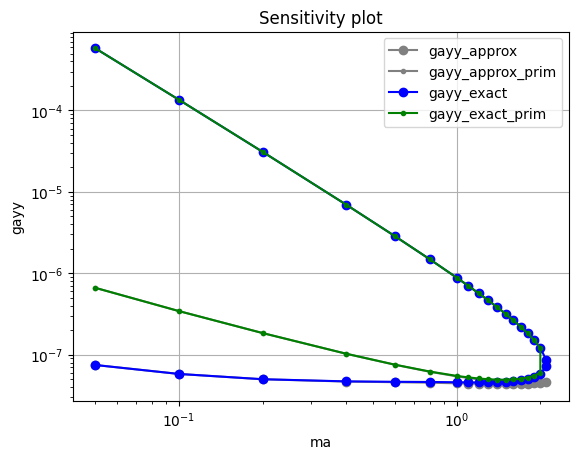

In [18]:
# Define x values (they'll be repeated for each y-value set)
ma_list = list(gayy_exact_vs_m.keys())

# Define y-values for each x (two y-values for each x)
gayy_exact_values_dwn = [value[0] for value in gayy_exact_vs_m.values()]
gayy_exact_values_up = [value[1] for value in gayy_exact_vs_m.values()]

gayy_approx=[value for value in gayy_LLP_lowbnd.values()]

# Define x values (they'll be repeated for each y-value set)
ma_list_prim = [key for key, value in gayy_exact_vs_m_prim.items() if value != [None, None]]
                         
# Define y-values for each x (two y-values for each x)
gayy_exact_values_dwn_prim = [value[0] for value in gayy_exact_vs_m_prim.values() if value[0]!=None]
gayy_exact_values_up_prim = [value[1] for value in gayy_exact_vs_m_prim.values() if value[1]!=None]

gayy_approx_prim=[value for key,value in gayy_LLP_lowbnd_prim.items() if  gayy_exact_vs_m_prim[key] != [None, None]]

# Combine the y-values into a single list
gayy_exact = gayy_exact_values_dwn + gayy_exact_values_up[::-1]

# Repeat the x-values to match the length of combined y-values
ma_dbl = ma_list+ma_list[::-1]

# Combine the y-values into a single list
gayy_exact_prim = gayy_exact_values_dwn_prim + gayy_exact_values_up_prim[::-1]

# Repeat the x-values to match the length of combined y-values
ma_dbl_prim = ma_list_prim+ma_list_prim[::-1]

# Plot the combined values, connecting all points in a single line
plt.plot(ma_list, gayy_approx, marker='o',linestyle='-', color='grey',label="gayy_approx")
plt.plot(ma_list_prim, gayy_approx_prim, marker='.',linestyle='-', color='grey',label="gayy_approx_prim")
plt.plot(ma_dbl, gayy_exact, marker='o',linestyle='-', color='b',label='gayy_exact')
plt.plot(ma_dbl_prim, gayy_exact_prim, marker='.',linestyle='-', color='g',label='gayy_exact_prim')
#plt.plot(x, y,linestyle='-', color='g')

# Label the axes
plt.xlabel('ma')
plt.ylabel('gayy')

plt.xscale('log')
plt.yscale('log')

# Title and grid for better visualization
plt.title('Sensitivity plot')
plt.grid(True)

plt.legend()
# Display the plot
plt.show()